# 05 Alternative regression model using MCMC + maximum likelihood 

> Implemented using metropolis hastings

In [1]:
#|default_exp core.05_alt_regression_model

In [2]:
#|hide
#import nbdev; nbdev.nbdev_export()

In [3]:
#|hide 
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj 
from dementia_inequalities import const, log, utils, tools 
import adu_proj.utils as adutils 

In [5]:
#|export 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

# pymc
import pymc as pm
from pymc import Normal, HalfNormal

#pyro
import os
import torch
import pyro
from torch import nn 
from pyro.nn import PyroModule


---

In [6]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [7]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,0.932,0.012269,0.480252,0.342754,0.604124,0.190731,0.061649,0.029487,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,0.630,0.006481,0.720170,0.201778,0.645599,0.103726,0.036506,0.012880,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,0.842,0.009222,0.551399,0.237524,0.626593,0.135847,0.048480,0.019880,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,0.878,0.009969,0.533413,0.239143,0.589346,0.136400,0.055064,0.021488,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,0.938,0.008057,0.488182,0.294860,0.625728,0.159655,0.062981,0.022507,77.360723,0.001138


In [8]:
# X and y data 

# covariates 
covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc']].values.reshape(-1,3)
#covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)
covar = covar.T

# Outcome data 
Y_data = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

In [9]:
covar[0].shape

(309,)

In [10]:
# basic_model = pm.Model()

# with basic_model:
#     # priors 
#     alpha = pm.Normal("alpha", mu=0, sigma=1)
#     beta = pm.Normal("beta", mu=0, sigma=1, shape=3)
#     sigma = pm.HalfNormal("sigma", sigma=1)

#     # expected value of line
#     line = alpha + beta[0]*covar[0]+beta[1]*covar[1]+beta[2]*covar[2]

#     # likelihood 
#     #y_obs = line + pm.HalfNormal("y_obs", sigma=sigma, observed=Y_data)
#     Y_obs = pm.Normal("Y_obs", mu=line, sigma=sigma, observed=Y_data)

In [11]:
# not able to call the model as it leads to lots of errors - so think I probably can't use pymc :( 

# with basic_model:
#     # draw 1000 posterior samples
#     idata = pm.sample()

In [12]:
# # for CI testing
# smoke_test = ('CI' in os.environ)
# assert pyro.__version__.startswith('1.8.6')
# pyro.set_rng_seed(1)

In [13]:
# # try pyro instead

# # X and y data 

# # covariates 
# data = torch.tensor(df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'DEM_afflicted_pc']].values, dtype=torch.float)

# x_data, y_data = data[:,:-1], data[:,-1]

# linear_reg_model = PyroModule[nn.Linear](3,1)

# # Define loss and optimize
# loss_fn = torch.nn.MSELoss(reduction='sum')
# optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
# num_iterations = 1500 if not smoke_test else 2

# def train():
#     # run the model forward on the data
#     y_pred = linear_reg_model(x_data).squeeze(-1)
#     # calculate the mse loss
#     loss = loss_fn(y_pred, y_data)
#     # initialize gradients to zero
#     optim.zero_grad()
#     # backpropagate
#     loss.backward()
#     # take a gradient step
#     optim.step()
#     return loss

# for j in range(num_iterations):
#     loss = train()
#     if (j + 1) % 50 == 0:
#         print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# # Inspect learned parameters
# print("Learned parameters:")
# for name, param in linear_reg_model.named_parameters():
#     print(name, param.data.numpy())

## Log normal distribution 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$


In [14]:
#|export 

def shift_log_normal_pdf(x, delta, mu, sigma):
    x_shift = x-delta
    norm_const = 1/((x_shift)*sigma*np.sqrt(2*np.pi))
    exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)
    return norm_const*exp_part

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_6428/1959514423.py:6: RuntimeWarning: invalid value encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)


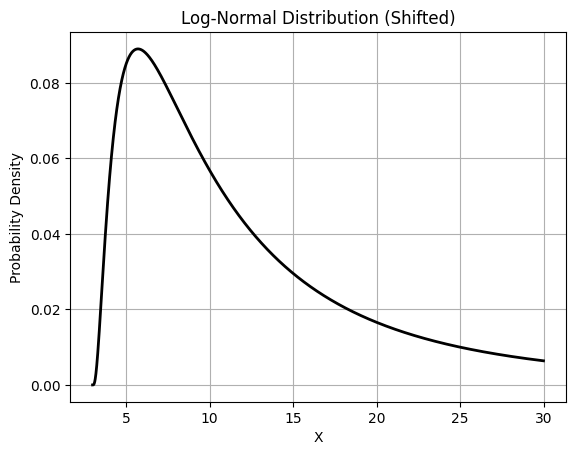

In [15]:
# Parameters for log-normal distribution
mu = 2  # Mean
sigma = 1  # Standard deviation
shift = 3 # Shift 

x = np.arange(1, 30, 0.01)

pdf_x = shift_log_normal_pdf(x, shift, mu, sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x, pdf_x, 'k-', linewidth=2)

plt.title('Log-Normal Distribution (Shifted)')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [16]:
# # Plot what the shifted log normal distribution looks like. 

# # Parameters for log-normal distribution
# mu = 2  # Mean
# sigma = 1  # Standard deviation

# x = np.arange(0,10, 0.01)
# shift = 3



# # Generate random samples from log-normal distribution
# samples = np.random.lognormal(mean=mu, sigma=sigma, size=1000)

# # Shift the samples to start at x=2
# samples += 2 - np.min(samples)

# # Plot the histogram of shifted samples
# plt.hist(samples, bins=50, density=True, alpha=0.6, color='pink')

# # Plot the log-normal probability density function (PDF)
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# pdf = (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x - (2 - np.min(samples))) - mu)**2 / (2 * sigma**2))
# plt.plot(x, pdf, 'k-', linewidth=2)

# plt.title('Log-Normal Distribution (Shifted)')
# plt.xlabel('X')
# plt.ylabel('Probability Density')
# plt.grid(True)
# plt.show()


### Used ChatGPT to write the framework for the log likelihood and the MCMC. 

However note: we need the likelihood to be the shifted log normal - which has an extra parameter (delta) compared to the log normal [see here](https://stats.stackexchange.com/questions/379980/understanding-the-shifted-log-normal-distribution). 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$

In the log-normal distribution, 
- $\mu$ is the scale parameter - it stretches and compresses
- $\sigma$ is a shape parameter - it controls how skewed/heavy tailed the distribution is. 

The shift is the linear equation: $\delta = \beta X$

So as a result the likelihood becomes: 

$$
L(\delta, \mu, \sigma) = \prod_{i=1}^n s(y_i | \beta X, \mu, \sigma) \\

= \prod_{i=1}^n \frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2}
$$

With a log-likelihood of: 

$$
= \sum_{i=1}^n log(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2})
\\ 
= \sum_{i=1}^n -\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2ln(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}}) 
\\ 
= -\frac{1}{2 \sigma^2} \sum_{i=1}^n (ln(y_i- \beta X_i)-\mu)^2ln(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}}) 
\\ 
= \frac{1}{2 \sigma^2} \sum_{i=1}^n (ln(y_i- \beta X_i)-\mu)^2ln((y_i-\beta X_i)\sigma \sqrt{2 \pi}) 
$$


In [24]:
# Define the log likelihood function for linear regression with log-normal error
def log_likelihood(params, X, y):
    beta = params[:-2]
    mu = params[-2]
    sigma = params[-1]
    y_pred = np.dot(X, beta)
    y_shift = y - y_pred
    log_likelihood = ((np.log(y_shift) - mu)**2)*(np.log(y_shift*sigma*np.sqrt(2*np.pi)))
    log_likelihood_sum = (1/(2*sigma**2)) * np.sum(log_likelihood)
    #error = np.log(y) - np.log(y_pred) - mu
    #error = np.log(y)- np.log(y_pred) - np.sqrt(2)/(sigma*np.sqrt(np.pi))*np.exp(-y_pred**2/(2*sigma**2))
    #log_likelihood_value = -0.5 * np.sum(error**2 / sigma**2 + np.log(2 * np.pi * sigma**2))
    return log_likelihood_sum

# Define the prior distribution for beta parameters, mu, and sigma
def log_prior(params):
    beta = params[:-2]
    mu = params[-2]
    sigma = params[-1]
    if np.all(-10 < beta.all() < 10) and 0 <= mu < 10 and sigma > 0:
        return 0
    return -np.inf

# Define the log posterior distribution
def log_posterior(params, X, y):
    return log_likelihood(params, X, y) + log_prior(params)

# Define the Metropolis-Hastings algorithm
def metropolis_hastings(initial_params, proposal_sd, n_iter, X, y):
    params = initial_params
    accepted_params = [params]
    for _ in range(n_iter):
        proposed_params = params + np.random.normal(scale=proposal_sd, size=params.shape)
        log_alpha = log_posterior(proposed_params, X, y) - log_posterior(params, X, y)
        if np.log(np.random.rand()) < log_alpha:
            params = proposed_params
        accepted_params.append(params)
    return np.array(accepted_params)


In [25]:
log_likelihood(initial_params, X, y)

3909.6805098679747

In [30]:
# Generate some sample data with 7 covariates
np.random.seed(0)
n_samples = 1000
n_features = 7
X = np.random.rand(n_samples, n_features) * 10  # Independent variables
true_beta = np.random.normal(loc=2, scale=1, size=n_features)  # True coefficients
true_mu = 0  # True mean of log-normal distribution
true_sigma = 1
true_error = np.random.lognormal(mean=true_mu, sigma=true_sigma, size=n_samples)  # Log-normal error term
y = np.dot(X, true_beta) + true_error  # True relationship with error

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_6428/2105655618.py:8: RuntimeWarning: invalid value encountered in log
  log_likelihood = ((np.log(y_shift) - mu)**2)*(np.log(y_shift*sigma*np.sqrt(2*np.pi)))


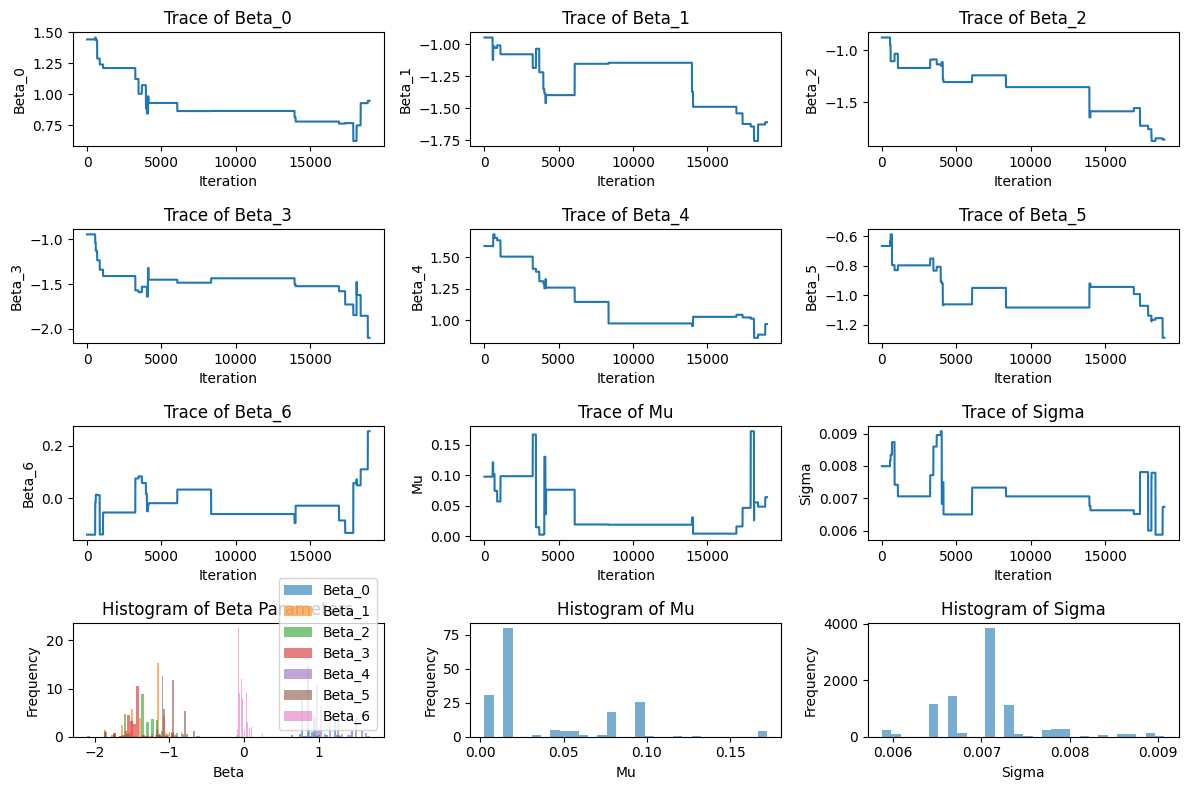

In [34]:
# Set initial parameters and proposal standard deviation
initial_params = np.concatenate([np.random.normal(size=n_features), [0, 1]])  # Initial beta parameters, mu, and sigma
proposal_sd = 0.1

# Run Metropolis-Hastings algorithm
n_iter = 20000
chain = metropolis_hastings(initial_params, proposal_sd, n_iter, X, y)

# Burn-in (discard first part of the chain)
burn_in = 1000
burned_chain = chain[burn_in:]

# Extract beta parameters, mu, and sigma from the chain
beta_samples, mu_samples, sigma_samples = burned_chain[:, :-2], burned_chain[:, -2], burned_chain[:, -1]

# Plot the traces and histograms of beta parameters, mu, and sigma
plt.figure(figsize=(12, 8))

for i in range(n_features):
    plt.subplot(4, 3, i+1)
    plt.plot(beta_samples[:, i])
    plt.xlabel('Iteration')
    plt.ylabel(f'Beta_{i}')
    plt.title(f'Trace of Beta_{i}')

plt.subplot(4, 3, n_features+1)
plt.plot(mu_samples)
plt.xlabel('Iteration')
plt.ylabel('Mu')
plt.title('Trace of Mu')

plt.subplot(4, 3, n_features+2)
plt.plot(sigma_samples)
plt.xlabel('Iteration')
plt.ylabel('Sigma')
plt.title('Trace of Sigma')

plt.subplot(4, 3, n_features+3)
for i in range(n_features):
    plt.hist(beta_samples[:, i], bins=30, density=True, alpha=0.6, label=f'Beta_{i}')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.title('Histogram of Beta Parameters')
plt.legend()

plt.subplot(4, 3, n_features+4)
plt.hist(mu_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Mu')
plt.ylabel('Frequency')
plt.title('Histogram of Mu')

plt.subplot(4, 3, n_features+5)
plt.hist(sigma_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.title('Histogram of Sigma')

plt.tight_layout()
plt.show()


In [35]:
# Extract the mode (most frequent value) from the parameter samples
mode_beta = np.median(beta_samples, axis=0)
mode_mu = np.median(mu_samples)
mode_sigma = np.median(sigma_samples)

print("MAP estimates:")
print("Beta:", mode_beta)
print("Mu:", mode_mu)
print("Sigma:", mode_sigma)

MAP estimates:
Beta: [ 0.86723157 -1.15240001 -1.35630607 -1.45031347  1.02694176 -0.99345997
 -0.05483679]
Mu: 0.018930730075810663
Sigma: 0.007057965149159625


In [36]:
print("True parameter values:")
print("Beta:", true_beta)
print("Mu:", true_mu)
print("Sigma:", true_sigma)

True parameter values:
Beta: [2.33262315 4.49599456 2.3348725  2.24408513 0.91852546 0.32878941
 3.0294515 ]
Mu: 0
Sigma: 1
